# Seq2Seq_Attension
實現機器翻譯(Machine Translation)，輸入一句英文句子，輸出一句法文句子
<br>輸入 : his least liked fruit is the apple , but your least liked is the strawberry .
<br>輸出 : son fruit est moins aimé la pomme , mais votre moins aimé est la fraise .
<br>在這支程式中加入Attension機制，強化Seq2Seq

在一般的Seq2Seq模型的inference階段中，如果Sequence中在t時刻中產生錯誤的值，在t時刻之後的輸入狀態將會受到影響，而該誤差會隨著生成過程不斷向後累積；而Scheduled Sampling以一定概率將Decoder自己產生的值作為Decoder端的輸入，這樣即使前面產生錯誤的值，其目標仍然是最大化真實目標序列的概率，模型會朝著正確的方向進<br>

在訓練早期Scheduled Sampling主要使用target中的真實值作為Decoder端的輸入，可以將模型從隨機初始化的狀態快速引導至一個合理的狀態；隨著訓練的進行，該方法會逐漸更多地使用Decoder自己產生的值作為Decoder端的輸入，以解決數據分布不一致的問題<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import time
import tensorflow as tf
import copy
import random
from tensorflow.python.layers.core import Dense
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# 讀取數據

In [2]:
# English source data
f_eng = open('data/small_vocab_en' , 'r' , encoding = 'utf-8')
source_letter = []
source_sentence = []
while True:
    raw = f_eng.readline()
    if raw == '' : break

    sentence = raw.split('\n')[0] 
    temp_sentence = []
    for word in sentence.split(' '):
        if len(word) != 0:
            source_letter.append(word.lower())
            temp_sentence.append(word.lower())
    source_sentence.append(temp_sentence)    

    
# French target data
f_fre = open('data/small_vocab_fr', 'r', encoding='utf-8')       
target_letter = []
target_sentence = []
while True:
    raw = f_fre.readline()
    if raw == '' : break

    sentence = raw.split('\n')[0]   
    temp_sentence = []
    for word in sentence.split(' '):
        if len(word) != 0:
            target_letter.append(word.lower())
            temp_sentence.append(word.lower())
    target_sentence.append(temp_sentence)    

# 數據預處理

In [3]:
special_words = ['<PAD>' , '<UNK>' , '<GO>' , '<EOS>']

# 建造英文詞庫
source_letter = list(set(source_letter)) + special_words[:2] # 加入 '<PAD>' , '<UNK>'              
source_letter_to_int = {word : idx for idx , word in enumerate(source_letter)}   
source_int_to_letter = {idx : word for idx , word in enumerate(source_letter)}   

# 建造法文詞庫
target_letter = list(set(target_letter)) + special_words # 加入 '<PAD>' , '<UNK>' , '<GO>' , '<EOS>'       
target_letter_to_int = {word : idx for idx , word in enumerate(target_letter)}   
target_int_to_letter = {idx : word for idx , word in enumerate(target_letter)}

In [4]:
# 將所有字母轉換成index
source_int = []
for sentence in source_sentence:
    temp = []
    for letter in sentence:
        if letter in source_letter_to_int.keys():
            temp.append(source_letter_to_int[letter])  
        else:
            temp.append(source_letter_to_int['<UNK>'])
    source_int.append(temp)           
            
target_int = []
for sentence in target_sentence:
    temp = []
    for letter in sentence:
        if letter in target_letter_to_int.keys():
            temp.append(target_letter_to_int[letter])
        else:
            temp.append(target_letter_to_int['<UNK>'])
    temp.append(target_letter_to_int['<EOS>'])          
    target_int.append(temp)       

In [5]:
# 超參數
# Number of Epochs
epochs = 200
# Batch Size
batch_size = 130
# RNN Size
rnn_hidden_unit = 128
# Number of Layers
num_layers = 1
# Embedding Size
encoding_embedding_size = 100
decoding_embedding_size = 100

# Build Model

## 輸入層

In [6]:
input_data = tf.placeholder(tf.int32 , [None , None] , name = 'inputs')
targets = tf.placeholder(tf.int32 , [None , None] , name = 'targets')
from_model_or_target = tf.placeholder(tf.float32 , [] , name = 'from_model_or_target')

source_sequence_length = tf.placeholder(tf.int32 , [None ,] , name = 'source_sequence_length')
target_sequence_length = tf.placeholder(tf.int32 , [None ,] , name = 'target_sequence_length')
# 決定target序列最大長度（之後target_sequence_length和source_sequence_length會作為feed_dict的參數）
max_target_sequence_length = tf.reduce_max(target_sequence_length , name = 'max_target_len')

## Encoder

需要對source數據進行embedding，再傳入Decoder中的RNN

In [7]:
# input_data: 輸入tensor
# rnn_hidden_unit: rnn隱層結點數量
# num_layers: rnn cell的層數
# source_sequence_length: source數據的序列長度
# source_vocab_size: source數據的詞庫大小
# encoding_embedding_size: embedding的向量維度

# Encoder embedding
'''
encoder_embed_input = tf.contrib.layers.embed_sequence(input_data , source_vocab_size , encoding_embedding_size) 
                                                  ⇕ 相當於
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)

若懶得寫兩行程式可以直接用tf.contrib.layers.embed_sequence這個函數
介紹 : https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence
'''
source_vocab_size = len(source_letter_to_int)
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)

def get_lstm_cell(rnn_hidden_unit):
    lstm_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit, 
                                        initializer = tf.random_uniform_initializer(-0.1 , 0.1))
    return lstm_cell

cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(rnn_hidden_unit) for _ in range(num_layers)])

encoder_output, encoder_state = tf.nn.dynamic_rnn(cell, 
                                                  encoder_embed_input, 
                                                  sequence_length = source_sequence_length,
                                                  dtype = tf.float32)

## Decoder and Attention

In [8]:
# 預處理後的decoder輸入
# 在batch中每一筆data最前面加上<GO>，並移除最後一個字，所以每一筆data的詞的數目並無改變

# cut掉最後一個字
# ending = tf.strided_slice(targets , [0, 0] , [batch_size, -1] , [1, 1]) # 等同於 ending = tf.identity(targets[: , 0:-1])
ending = tf.identity(targets[: , 0:-1])
decoder_input = tf.concat([tf.fill([batch_size, 1] , target_letter_to_int['<GO>']) , ending] , axis = 1)

### tf.contrib.seq2seq.ScheduledEmbeddingTrainingHelper:(Training 階段，還有其他種類的Helper)
### 訓練時採用scheduled sampling，永遠把ground truth輸入給模型，不管模型前一步預測結果是否正確
train-decoder不再一直都是真實的lable數據作為下一個時刻的輸入<br>
train-decoder會以一個機率P選擇模型自身的輸出作為下一個預測的輸入，以1-p選擇真實標記作為下一個預測的輸入<br>
scheduled sampling，即機率P在訓練的過程中是變化的<br>
一開始訓練不充分，先讓P小一些，盡量使用真實的label作為輸入，隨著訓練的進行，將P增大，採用自身的輸出作為下一個預測的輸入<br>
隨著訓練的進行，P越來越大，train-decoder模型最終變來和inference-decoder預測模型一樣，消除了train-decoder與inference-decoder之間的差異
<br><br><br>

### tf.contrib.seq2seq.GreedyEmbeddingHelper:(Inference 階段，還有不同sample手段的Helper)
### 它和TrainingHelper的區別在於它會把t-1時刻的輸出經過embedding層作為t時刻的輸入
• greedy decoding：每一次把模型認為機率最大的 token 輸入給下一時刻<br>
• beam search decoding：每次保留 top k 的預測結果，解碼得到（近似） k best 序列 <br>
• sample decoding：每一步從模型預測的機率分布中隨機取樣一個 token 輸入給下一時刻

In [9]:
# decoding_embedding_size: embedding的向量維度
# num_layers: rnn cell的層數
# rnn_size: RNN單元的隱層結點數量
# target_sequence_length: target數據序列長度
# max_target_sequence_length: target數據序列最大長度
# encoder_state: encoder端編碼的狀態向量
# decoder_input: decoder端輸入

# 1. Embedding，需要對target數據進行embedding，再傳入Decoder中的RNN
target_vocab_size = len(target_letter_to_int)
decoder_embeddings = tf.Variable(tf.random_uniform([target_vocab_size , decoding_embedding_size]))
decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings , decoder_input)

# 2. 建造Decoder中的RNN單元
def get_decoder_cell(rnn_hidden_unit):
    decoder_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit,
                                           initializer = tf.random_uniform_initializer(-0.1 , 0.1))
    return decoder_cell
cell = tf.contrib.rnn.MultiRNNCell([get_decoder_cell(rnn_hidden_unit) for _ in range(num_layers)])
 
# 3. Output全連接層
output_layer = Dense(target_vocab_size,
                     kernel_initializer = tf.truncated_normal_initializer(mean = 0.0 , stddev = 0.1))
 
# 4. 加入Attention機制
attn_mech = tf.contrib.seq2seq.LuongAttention(num_units = rnn_hidden_unit ,
                                              memory = encoder_output ,
                                              memory_sequence_length = source_sequence_length)


attn_decoder = tf.contrib.seq2seq.AttentionWrapper(cell = cell ,
                                                   attention_mechanism = attn_mech , 
                                                   attention_layer_size = rnn_hidden_unit , 
                                                   alignment_history = True)
 
initial_state = attn_decoder.zero_state(batch_size , tf.float32).clone(cell_state = encoder_state)


# 5. Training decoder
with tf.variable_scope('decoder'):
    # tf.contrib.seq2seq.ScheduledEmbeddingTrainingHelper即是採用scheduled sampling的方法
    training_helper = tf.contrib.seq2seq.ScheduledEmbeddingTrainingHelper(inputs = decoder_embed_input ,
                                                                          sequence_length = target_sequence_length,
                                                                          embedding = decoder_embeddings ,
                                                                          sampling_probability = from_model_or_target ,
                                                                          time_major = False)

    # 建造decoder
    training_decoder = tf.contrib.seq2seq.BasicDecoder(attn_decoder ,
                                                       training_helper ,
                                                       initial_state ,
                                                       output_layer) 
    
    # decoder_output包含 rnn_output 與 sample_id
    # rnn_output: [batch_size, decoder_targets_length, vocab_size]，保存decode每個時刻每個單詞的概率，可以用來計算loss
    # sample_id: [batch_size], tf.int32，保存最終的編碼結果。可以表示最後的答案
    training_decoder_output ,\
    training_final_state ,\
    training_final_sequence_lengths =\
    tf.contrib.seq2seq.dynamic_decode(training_decoder,                                          
                                      impute_finished = True,
                                      maximum_iterations = max_target_sequence_length)
    
    attention_matrices = training_final_state.alignment_history.stack(name = 'train_attention_matrix')

    
with tf.variable_scope('decoder'):
    
    tf.get_variable_scope().reuse_variables() 
    
    # 創建一個常量tensor並覆制為batch_size的大小
    start_tokens = tf.tile(tf.constant([target_letter_to_int['<GO>']], dtype=tf.int32) ,
                           [batch_size] , 
                           name = 'start_tokens')
    
    # GreedyEmbeddingHelper採取argmax抽樣演算法來得到輸出id，並且經過embedding層作為下一時刻的輸入
    predicting_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(decoder_embeddings ,
                                                                 start_tokens ,
                                                                 target_letter_to_int['<EOS>'])
    
    predicting_decoder = tf.contrib.seq2seq.BasicDecoder(attn_decoder ,
                                                         predicting_helper ,
                                                         initial_state ,
                                                         output_layer)
  
    predicting_decoder_output ,\
    predicting_final_state ,\
    predicting_final_sequence_lengths=\
    tf.contrib.seq2seq.dynamic_decode(predicting_decoder,
                                      impute_finished = True,
                                      maximum_iterations = max_target_sequence_length)  

    # 產生attention矩陣，有助於最後可視化結果
    predicting_attention_matrices = predicting_final_state.alignment_history.stack(name = 'inference_attention_matrix')                                                                                    

In [10]:
training_logits = tf.identity(training_decoder_output.rnn_output ,  name = 'logits')
predicting_logits = tf.identity(predicting_decoder_output.sample_id ,  name = 'predictions')

'''
target_sequence_length : [4 , 2 , 3]

max_target_sequence_length : 8

=> masks的輸出長這樣 : 1 1 1 1 0 0 0 0  (4)
                       1 1 0 0 0 0 0 0  (2)
                       1 1 1 0 0 0 0 0  (3)
-> 0的部分代表是補0的地方，不列入loss的計算，可以加快運算速度
'''                
               
masks = tf.sequence_mask(target_sequence_length , 
                         max_target_sequence_length, 
                         dtype = tf.float32, 
                         name = 'masks')


with tf.variable_scope('optimization'):        
    # Loss function
    cost = tf.contrib.seq2seq.sequence_loss(training_logits,
                                            targets,
                                            masks)

    # Optimizer
    optimizer = tf.train.AdamOptimizer(1e-3)

    # Gradient Clipping
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad , -1. , 1.), var) for grad, var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)

C:\Users\hong guo peng\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\hong guo peng\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Batches

In [11]:
def get_batches(source , target , index = None , on_train = False):  
    if on_train:
        source = np.array(source)[index]    
        target = np.array(target)[index]   
    else:
        source = np.array(source)
        target = np.array(target)
        
    # 決定source與target中的最大長度
    source_max_length , target_max_length = 0 , 0  
    for vob_source , vob_target in zip(source , target):
        if len(vob_source) > source_max_length:
            source_max_length = len(vob_source)    
        if len(vob_target) > target_max_length:
            target_max_length = len(vob_target)  
 
    # 分別對source與target補source_letter_to_int['<PAD>']與target_letter_to_int['<PAD>']到最大長度  
    source_pad , target_pad = [] , []
    source_len , target_len = [] , []
    for source_sentence , target_sentence in zip(source , target):
        source_len.append(len(source_sentence)) # 收集source中每個sencentence的長度
        temp_source = source_sentence.copy()
        while len(temp_source) < source_max_length:
            temp_source.append(source_letter_to_int['<PAD>']) 
        source_pad.append(temp_source)
        
        target_len.append(len(target_sentence)) # 收集target中每個sencentence的長度
        temp_target = target_sentence.copy()
        while len(temp_target) < target_max_length:
            temp_target.append(target_letter_to_int['<PAD>']) 
        target_pad.append(temp_target) 
        
    return np.array(source_pad) , np.array(target_pad) , np.array(source_len) , np.array(target_len)     

In [12]:
# 將數據集分割為train和validation
train_source = source_int[batch_size:]
train_target = target_int[batch_size:]
# 留出一個batch進行驗證
valid_source = source_int[:batch_size]
valid_target = target_int[:batch_size]

## Training

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

prob = 1e-3
alpha = 1.5
stop_early = 0
for epoch_i in range(0 , epochs):
    
    # 在每進行一個epoch前，把每個batch的index先決定出來
    batch_index = []
    temp = []
    count = 0 
    while len(batch_index) <= 1059: 
        temp.append(count)
        count += 1
        if len(temp) == batch_size:
            batch_index.append(temp)
            temp = []
        if count == len(train_source):
            count = 0
            
    coin_tossing = np.random.choice(a = 2 , 
                                    size = 1 , 
                                    replace = True , 
                                    p = [prob , 1 - prob])[0]
    if alpha * prob < 1  : prob = alpha * prob # p會隨著epoch增加越來越大
    elif alpha * prob > 1: prob = 1.

    for batch_i in range(0 , 1059):
        train_source_batch_pad , \
        train_target_batch_pad , \
        train_source_batch_length , \
        train_target_batch_length = get_batches(source = train_source ,
                                                target = train_target , 
                                                index = batch_index[batch_i] , 
                                                on_train = True)
        
        _ , loss =\
        sess.run([train_op , cost],
                 feed_dict = {input_data : train_source_batch_pad ,
                              targets : train_target_batch_pad ,
                              source_sequence_length : train_source_batch_length ,
                              target_sequence_length : train_target_batch_length , 
                              from_model_or_target : coin_tossing})
        
    valid_source_pad , \
    valid_target_pad , \
    valid_source_length , \
    valid_target_length = get_batches(source = valid_source ,
                                      target = valid_target)

    validation_loss , predicting_logits_result =\
    sess.run([cost , predicting_logits] ,
             feed_dict = {input_data : valid_source_pad ,
                          targets : valid_target_pad ,
                          source_sequence_length : valid_source_length , 
                          target_sequence_length : valid_target_length , 
                          from_model_or_target : coin_tossing})

    print('=' *  30)
    print('Epoch : {}/{} \nBatch : {}/{} \nstop_early : {} \nTraining Loss : {:.3f} \nValidation loss : {:.3f}'
          .format(epoch_i , epochs ,  
                  batch_i , len(train_source) // batch_size , 
                  stop_early , loss , validation_loss))

    index = np.random.randint(batch_size) # 隨機決定一筆data，查看翻譯的結果

    source_visualization = []
    for i in valid_source_pad[index]:
        if source_int_to_letter[i] == '<PAD>': break
        source_visualization.append(source_int_to_letter[i])
    source_visualization = ' '.join(source_visualization)

    target_visualization = []
    for i in valid_target_pad[index]:
        if target_int_to_letter[i] == '<EOS>': break
        target_visualization.append(target_int_to_letter[i])
    target_visualization = ' '.join(target_visualization)

    predict_visualization = []
    for i in predicting_logits_result[index]:
        if target_int_to_letter[i] == '<EOS>': break
        predict_visualization.append(target_int_to_letter[i])
    predict_visualization = ' '.join(predict_visualization)

    print('*' *  30)    
    print('Source  : {}'.format(source_visualization))
    print('Target  : {}'.format(target_visualization))
    print('Predict : {}\n'.format(predict_visualization))
    
    if coin_tossing == 0:
        stop_early += 1

    if stop_early == 20: # 當coin_tossing為0的次數為20時即停止計算
        break

# 保存模型
saver = tf.train.Saver()
saver.save(sess , 'trained_model/save_net')
print('Model Trained and Saved')

Epoch : 0/200 
Batch : 1058/1059 
stop_early : 0 
Training Loss : 0.821 
Validation loss : 0.869
******************************
Source  : they are going to france next june .
Target  : ils vont en france en juin prochain .
Predict : ils vont aller en chine juin .

Epoch : 1/200 
Batch : 1058/1059 
stop_early : 0 
Training Loss : 0.454 
Validation loss : 0.512
******************************
Source  : we like oranges , mangoes , and grapes .
Target  : nous aimons les oranges , les mangues et les raisins .
Predict : nous aimons les oranges , les mangues et les raisins .

Epoch : 2/200 
Batch : 1058/1059 
stop_early : 0 
Training Loss : 0.334 
Validation loss : 0.389
******************************
Source  : he saw a old yellow truck .
Target  : il a vu un vieux camion jaune .
Predict : il a vu un petit camion jaune .

Epoch : 3/200 
Batch : 1058/1059 
stop_early : 0 
Training Loss : 0.263 
Validation loss : 0.277
******************************
Source  : he dislikes lemons , grapes , and ma

Epoch : 21/200 
Batch : 1058/1059 
stop_early : 6 
Training Loss : 0.013 
Validation loss : 0.012
******************************
Source  : china is warm during spring , and it is sometimes cold in february .
Target  : chine est chaud au printemps , et il est parfois froid en février .
Predict : chine est chaud au printemps , et il est parfois froid en février .

Epoch : 22/200 
Batch : 1058/1059 
stop_early : 7 
Training Loss : 0.016 
Validation loss : 0.011
******************************
Source  : the grapefruit is my most loved fruit , but the banana is her most loved .
Target  : le pamplemousse est mon fruit le plus cher , mais la banane est la plus aimée .
Predict : le pamplemousse est mon fruit le plus cher , mais la banane est la plus aimée .

Epoch : 23/200 
Batch : 1058/1059 
stop_early : 8 
Training Loss : 0.011 
Validation loss : 0.012
******************************
Source  : china is sometimes pleasant during march , but it is usually nice in may .
Target  : la chine est par

the mango is your least liked fruit , but the apple is my least liked . <PAD>
votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme . <EOS> janvier janvier janvier janvier janvier


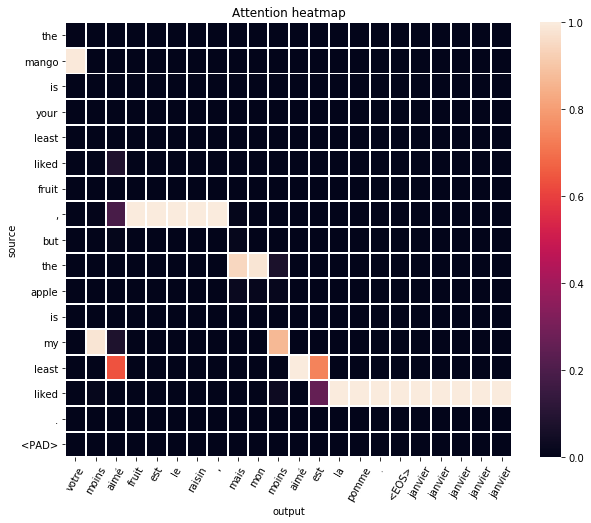

In [14]:
att , predicting_logits_ = sess.run([predicting_attention_matrices , predicting_logits], 
                                     feed_dict = {input_data : valid_source_pad ,
                                                  targets : valid_target_pad ,
                                                  source_sequence_length : valid_source_length , 
                                                  target_sequence_length : valid_target_length , 
                                                  from_model_or_target : coin_tossing})    


# 隨機取一個樣本 i 畫出注意力矩陣
i = 4
matrix = att[: , i , ].T
src = train_source_batch_pad[i , :]
tgt = predicting_logits_[i , :]    

src_letter , tgt_letter = [] , []
for item in src:
    src_letter.append(source_int_to_letter[item])
for item in tgt :
    tgt_letter.append(target_int_to_letter[item])
print(' '.join(src_letter))
print(' '.join(tgt_letter))

df = pd.DataFrame(matrix , index = src_letter , columns = tgt_letter)
plt.figure(figsize=(10 , 8))
ax = sns.heatmap(df , linewidths = 1)
ax.set_xlabel('output')
ax.set_ylabel('source')
plt.xticks(rotation = 60)
plt.yticks(rotation = 0)
ax.set_title('Attention heatmap')
plt.show()

## Testing

In [16]:
import os    
sess = tf.Session()
new_saver = tf.train.import_meta_graph(os.path.join('trained_model/save_net.meta'))
new_saver.restore(sess, tf.train.latest_checkpoint(os.path.join('trained_model')))

graph = tf.get_default_graph()
input_data = graph.get_tensor_by_name('inputs:0')
targets = graph.get_tensor_by_name('targets:0')
source_sequence_length = graph.get_tensor_by_name('source_sequence_length:0')
target_sequence_length = graph.get_tensor_by_name('target_sequence_length:0')
logits = graph.get_tensor_by_name('predictions:0')
from_model_or_target = graph.get_tensor_by_name('from_model_or_target:0')

input_sentence = 'i dislike grapefruit , lemons , and peaches .'
test_source = []
for letter in input_sentence.split(' '):
    if letter in source_letter_to_int.keys():
        test_source.append(source_letter_to_int[letter])
    elif letter not in source_letter_to_int.values():
        test_source.append(source_letter_to_int['<UNK>'])
test_source = [test_source] * batch_size
test_source_length = [len(i) for i in test_source]
           
test_target = [0 for _ in range(0 , 100)] # test_target輸入的值可以隨便選，只要長度大於test_source即可
test_target = [test_target] * batch_size
test_target_length = [len(i) for i in test_target]

test_source = np.array(test_source)
test_target = np.array(test_target)
test_source_length = np.array(test_source_length)
test_target_length = np.array(test_target_length)

answer = sess.run(logits, feed_dict = {input_data : test_source ,
                                       targets : test_target ,
                                       source_sequence_length : test_source_length ,
                                       target_sequence_length : test_target_length , 
                                       from_model_or_target : coin_tossing})

answer = answer[0 , :]
answer_to_letter = []
for num in answer:
    if target_int_to_letter[num] == '<EOS>': break
    answer_to_letter.append(target_int_to_letter[num])

print('輸入的英文句子 : {}'.format(input_sentence))  
print('google翻譯的法文句子 : {}'.format("je n'aime pamplemousses , les citrons et les pêches ."))  
print('model翻譯的法文句子  : {}'.format(' '.join(answer_to_letter)))      

INFO:tensorflow:Restoring parameters from trained_model\save_net
輸入的英文句子 : i dislike grapefruit , lemons , and peaches .
google翻譯的法文句子 : je n'aime pamplemousses , les citrons et les pêches .
model翻譯的法文句子  : je n'aime pamplemousses , les citrons et les pêches .
